In [ ]:
try:
    import dolfinx
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/ebd1b62/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [ ]:
try:
  import matplotlib
except ImportError:
  !pip install matplotlib
  import matplotlib

In [ ]:
#DOLFINx version: 0.8.0

# FEM za 1D Poissonov problem
#   -u'' = x*(1-x) na intervalu (0,1)
#   u(0) = u(1) = 0
#   egzaktno rješenje u = x^4/12 - x^3/6 + x/12

from dolfinx import mesh, fem, io, plot
from dolfinx.fem.petsc import assemble_matrix, create_vector, assemble_vector, apply_lifting, LinearProblem
from dolfinx.fem import assemble_scalar
from petsc4py import PETSc

import ufl

from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt

mpi_comm = MPI.COMM_WORLD

import pyvista
print(pyvista.global_theme.jupyter_backend)

error_array = {}

trame


In [ ]:
for i in range (10, 2000, 200):
#if you are using the for loop, ensure you change the "nx" parameter to something iterable, not a fixed value!

  # Domena i funkcijski prostor
  #---------------------------------------------------------
  nx = i
  domena = mesh.create_unit_interval(mpi_comm, nx)
  x = ufl.SpatialCoordinate(domena)
  V = fem.functionspace(domena, ('Lagrange', 1))

  uh = fem.Function(V)


  # Rub domene i rubni uvjeti
  #---------------------------------------------------------
  dim_domena = domena.topology.dim
  dim_rub = dim_domena - 1
  domena.topology.create_connectivity(dim_rub, dim_domena)

  # stupnjevi slobode nisu isto što i čvorovi mesha. To vrijedi samo za P1 elemente
  rub_indeks = mesh.exterior_facet_indices(domena.topology)
  rub_dofs = fem.locate_dofs_topological(V, dim_rub, rub_indeks)

  u_rub = fem.Constant(domena, PETSc.ScalarType(0))
  rubni_uvjet = fem.dirichletbc(u_rub, rub_dofs, V)


  # Pobuda
  #---------------------------------------------------------
  f = fem.Function(V)
  f.interpolate(lambda x: 2*x[0])


  # Slaba formulacija
  #---------------------------------------------------------
  u, v = ufl.TrialFunction(V), ufl.TestFunction(V)

  a = (1+x[0]) * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
  L = f * v * ufl.dx


  # Asembliranje i rješavanje sustava
  #---------------------------------------------------------
  problem = fem.petsc.LinearProblem(a, L, bcs=[rubni_uvjet])
  uh = problem.solve()


  # Stvarno rješenje
  #---------------------------------------------------------
  n_egz = 1000
  domena_egz = mesh.create_unit_interval(mpi_comm, n_egz)
  V_egz = fem.functionspace(domena_egz, ('Lagrange', 1))
  u_egz = fem.Function(V_egz)
  u_egz.interpolate(lambda x: -np.power(x[0],2)/2 + x[0] - np.log(1+x[0])*(1/np.log(4)))


  V2 = fem.functionspace(domena, ("Lagrange", 2))
  uex = fem.Function(V2)
  uex.interpolate(lambda x: -np.power(x[0],2)/2 + x[0] - np.log(1+x[0])*(1/np.log(4)))


  L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
  error_local = fem.assemble_scalar(L2_error)
  error_L2 = np.sqrt(domena.comm.allreduce(error_local, op=MPI.SUM))

  error_array[i] = error_L2

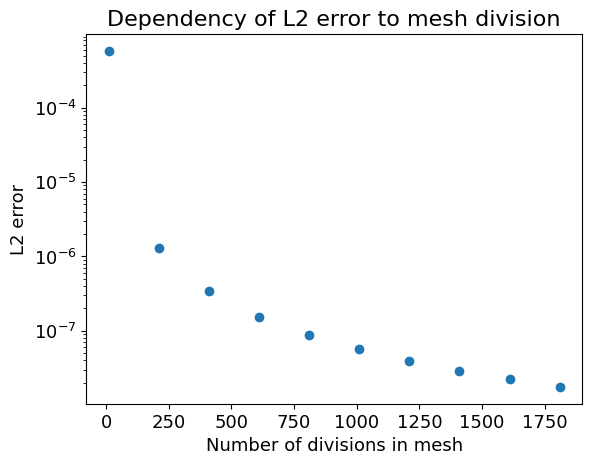

In [ ]:
res_array = np.array(list(error_array.items()))

step_array = res_array[:,0]
error_array = res_array[:,1]
#print(error_array)


# plotting the given graph in a scatter plot, setting the y-axis scale to a logarithmic scale

plt.scatter(step_array, error_array)
plt.title('Dependency of L2 error to mesh division', fontsize=16)
plt.xlabel('Number of divisions in mesh', fontsize=13)
plt.ylabel('L2 error', fontsize=13)
plt.yscale("log")


# show the plot
plt.show()

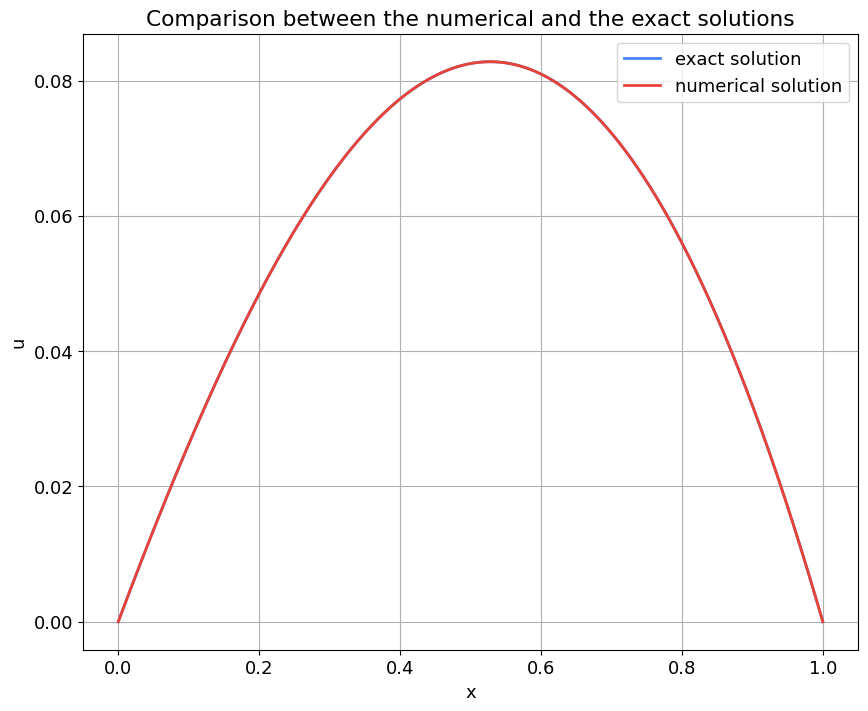

In [ ]:
# Graph
#---------------------------------------------------------
cells, types, x = plot.vtk_mesh(V)
cells_egz, types_egz, x_egz = plot.vtk_mesh(V_egz)

'''
u_grid = pyvista.UnstructuredGrid(cells, types, x)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
if not pyvista.OFF_SCREEN:
    plotter2.show()
'''

plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(x_egz[:,0], u_egz.x.array.real, linewidth=2, color = '#4285F4', label = 'exact solution')
plt.plot(x[:,0], uh.x.array.real, linewidth=2, color = '#EA4335', label = 'numerical solution')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('u')
ax.set_title('Comparison between the numerical and the exact solutions')
plt.grid()
#plt.savefig('./rezultati/poisson1D_rjesenje.png', bbox_inches='tight')
plt.show()
plt.close()